# Importando Bibliotecas e Funções

In [1]:
#importando módulos
import functions
from functions import *

In [3]:
#caminho para as requisicoes
stream_req = 'https://v3.football.api-sports.io/fixtures?date='
odds_req = 'https://v3.football.api-sports.io/odds?fixture='

# 3. Odds Históricas

In [4]:
#cria um range de datas para +- X dias

from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

import datetime
#seleciona a range de datas
x_dias_inicio = 10
x_dias_fim = 1

#date = hoje, datet0 = hoje - X dias, datet1 = hoje + X dias
datet0 = (datetime.date.today()) + datetime.timedelta(days=-x_dias_inicio)
datet1 = (datetime.date.today()) + datetime.timedelta(days=+x_dias_fim)

#escolher data inicio e fim - opcoes (date = hoje, datet0 = hoje - X dias, datet1 = hoje + X dias)

#data inicio
print(datet0)

#data fim
print(datet1)

#puxa as datas de inicio até a data fim
date_list = (pd.date_range(start=datet0, end=datet1,
                           freq='D')).strftime('%Y-%m-%d').tolist()

#traz a lista de jogos que ocorrerão na durante o período selecionado
df_stream = pd.concat([req_padrao(stream_req,i) for i in date_list])

#filtra as partidas de acordo com critérios
     #todas as partidas
df_stream
     #partidas que ja ocorreram
df_stream_finished = df_stream[df_stream['fixture.status.long']=="Match Finished"]    
     #partidas que ainda nao ocorreram
df_stream_notstarted = df_stream[df_stream['fixture.status.long']=="Not Started"]

#cria uma lista com as fixture.ids para iterar
     #todas as partidas
df_stream_list = list(df_stream['fixture.id'])
     #partidas que ja ocorreram
df_stream_finished_list = list(df_stream_finished['fixture.id']) 
     #partidas que ainda nao ocorreram
df_stream_notstarted_list = list(df_stream_notstarted['fixture.id'])

2023-05-01
2023-05-12


In [6]:
#baixar odds de partidas futuras
    #use pslgns
print(len(df_stream_list))

#baixar odds de partidas passadas
    #use pslgfs
print(len(df_stream_finished_list))

#baixar odds de partidas futuras e passadas
    #use partidas_stream
print(len(df_stream_notstarted_list))

4946
4371
463


In [8]:
#faz a requisicao das odds
df_st_l = df_stream_notstarted_list.copy()

cf_odds = pd.concat([req_padrao(odds_req,i) for i in df_st_l])

In [9]:
#da parse no json, transforma as odds em formato long e cria a coluna fixture.id para possibilitar identificacao

cf_odds_db = []

for i,j in zip(range(cf_odds.shape[0]),cf_odds['fixture.id'].unique()):
    cfo = json_normalize((cf_odds.iloc[i,:])['bookmakers'])
    cfo = flatten_nested_json_df(cfo.explode('bets'))
    cfo['bets.values.odd'] = cfo['bets.values.odd'].astype(float)
    cfo = cfo.drop(columns = 'index').reset_index(drop = True)
    cfo['fixture.id'] = j
    name = str(j) + '_' + str(cf_odds.iloc[i,:]['league.season']) + '_' +str(cf_odds.iloc[i,:]['league.country'])
    
    #salva os dados em csv para cada partida
    # cfo.to_csv(f'C:\\Users\\vinicius.felizatti\\Desktop\\Bets Brain\\odds_bd\\{name}.csv')
    cf_odds_db.append(cfo)

In [13]:
cf_odds_db = pd.concat(cf_odds_db)

cf_odds_db

,id,name,bets.id,bets.name,bets.values.value,bets.values.odd,fixture.id
0,6,Bwin,1,Match Winner,Home,1.93,1005690
1,6,Bwin,1,Match Winner,Draw,3.40,1005690
2,6,Bwin,1,Match Winner,Away,4.10,1005690
3,6,Bwin,2,Home/Away,Home,1.37,1005690
4,6,Bwin,2,Home/Away,Away,2.80,1005690
...,...,...,...,...,...,...,...
421,20,Betcris,38,Exact Goals Number,5,9.50,1004121
422,20,Betcris,38,Exact Goals Number,more 6,12.00,1004121
423,21,888Sport,1,Match Winner,Home,2.80,1004121
424,21,888Sport,1,Match Winner,Draw,3.35,1004121


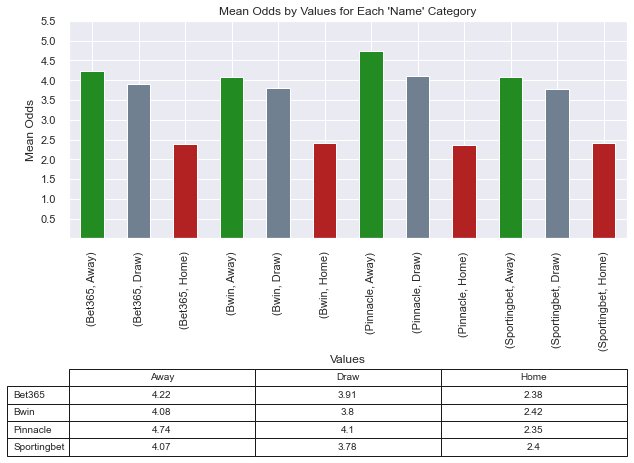

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
sns.set()

odds_category = 'Match Winner'

# Filtered and grouped data
grouped_data = cf_odds_db[(cf_odds_db['name'].isin(['Bet365', 'Sportingbet', 'Bwin', 'Pinnacle'])) & 
                          (cf_odds_db['bets.name'] == odds_category)].groupby(['name', 'bets.values.value']).mean()

# Setting the size of the figure
plt.figure(figsize=(10, 4))

# Plotting the bar chart
grouped_data['bets.values.odd'].plot(kind='bar', color=['forestgreen', 'slategrey', 'firebrick'])

# Setting the y-axis limits and tick locations
plt.ylim(0, 5.5)
plt.yticks([i * 0.5 for i in range(1, 12)])

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Mean Odds')
plt.title("Mean Odds by Values for Each 'Name' Category")


# Creating the table
table_data = grouped_data['bets.values.odd'].unstack().round(2)
table = plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index,
                  cellLoc='center', loc='bottom',  bbox=[0, -1, 1, 0.4])

# Formatting the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Adjusting x-axis tick labels
plt.xticks(rotation=90)

# Showing the plot
plt.show()
